# Computer Vision for Facial Age Recognition

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
	* [3.1. Explore](#exp)
	* [3.2. Findings](#find)
* [4. Modelling](#train)
* [5. Prepare Script to Run on GPU Platform](#prep)
* [6. Output](#out)
* [7. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

A supermarket franchise named Good Seed wants to determine if Data Science can help them comply with the law by ensuring that they do not sell age-restricted products to underage customers. You are tasked to carry out the evaluation. Therefore, as you begin your work, keep the following in mind:
The franchise stores are equipped with cameras at the cashier area that will display a signal when someone purchases an age-restricted product.
Computer vision methods can be used to determine a person's age from a photo.
Your task is to build and evaluate a model to verify a person's age.
To start working on this task, you will be given a set of photos of people with their corresponding age labels.

### 1.2. Objectives

Build and evaluate a computer vision model to determine a person's age from a photo.

### 1.3. Data Description

The data used for this research are:
* final_files folder with 7,600 photos
* labels.csv containing labels, with two columns: file_name and real_age

Dataset can be found on [APPA-REAL database](https://chalearnlap.cvc.uab.cat/dataset/26/description/#) or [Kaggle](https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped)

N.B. It is recommended to use generator to process the images.

### 1.4. Methodology

Steps taken in this research are:
1. Load dataset
2. EDA
3. Model Training
4. Model Analysis
5. Conclusion

## 2. Initiation <a id='init'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
np.random.seed(123)
SEED = 123

In [4]:
labels = pd.read_csv('datasets/faces/labels.csv')

## 3. Data Overview <a id='overview'></a>

### 3.1. Explore <a id='exp'></a>

In [5]:
labels.head(2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


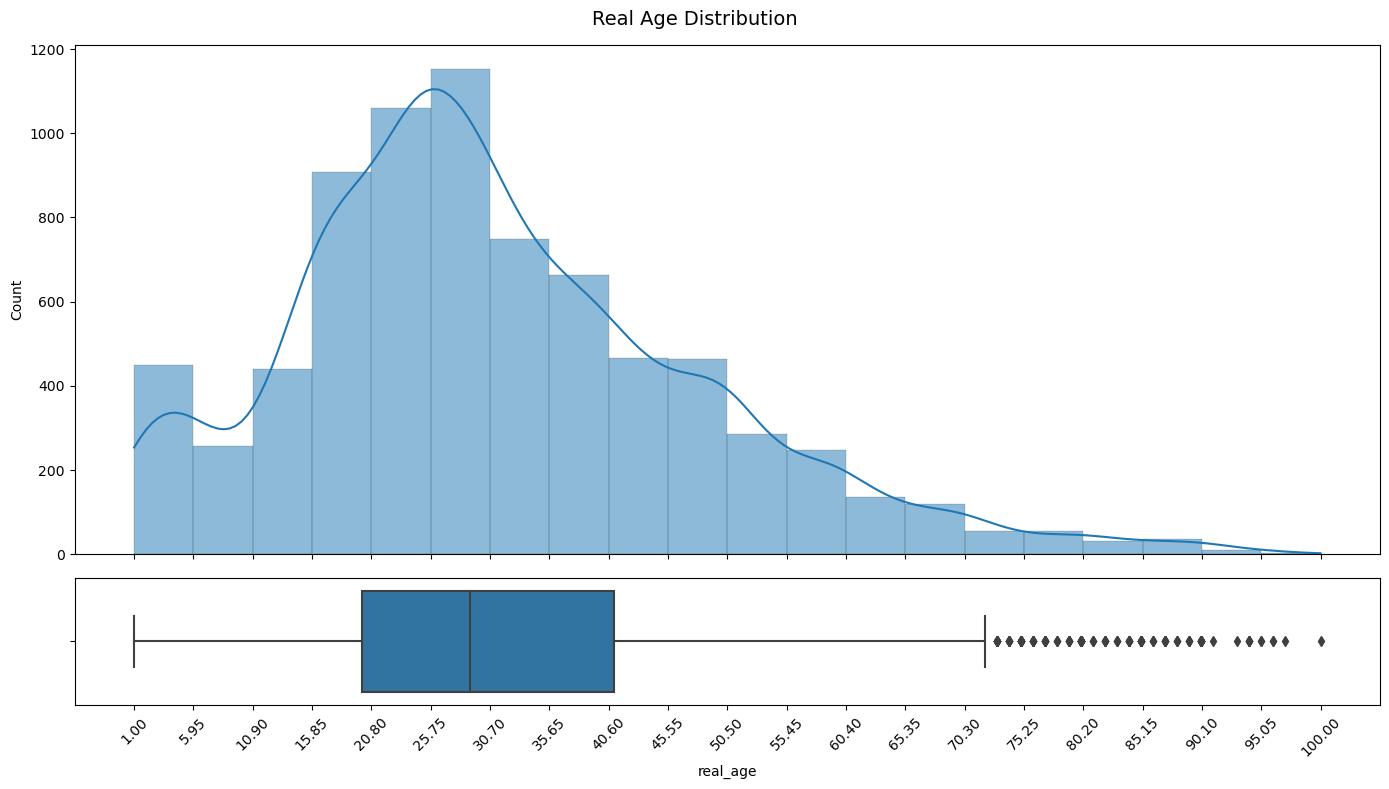

In [8]:
plt.style.use('default')
fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios': [2, 0.5]})
fig.suptitle('Real Age Distribution', fontsize=14)
sns.histplot(data=labels, x='real_age', kde=True, bins=20, linewidth=0.1, ax=ax[0])
sns.boxplot(data=labels, x='real_age', ax=ax[1])
plt.xticks(np.linspace(1,100,21), rotation=45)
plt.tight_layout()
plt.show()

In [9]:
data_gen = IDG(rescale=1/255)

data_gen_flow = data_gen.flow_from_dataframe(
    dataframe = labels,
    directory = 'datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'raw',
    seed = 12345)

Found 7591 validated image filenames.


In [10]:
def show_images(batch):
    fig = plt.figure(figsize=(12,12))
    
    for i in range(16):
        fig.add_subplot(4, 4, i+1).set_title(batch[1][i])
        plt.imshow(batch[0][i])

    fig.tight_layout()

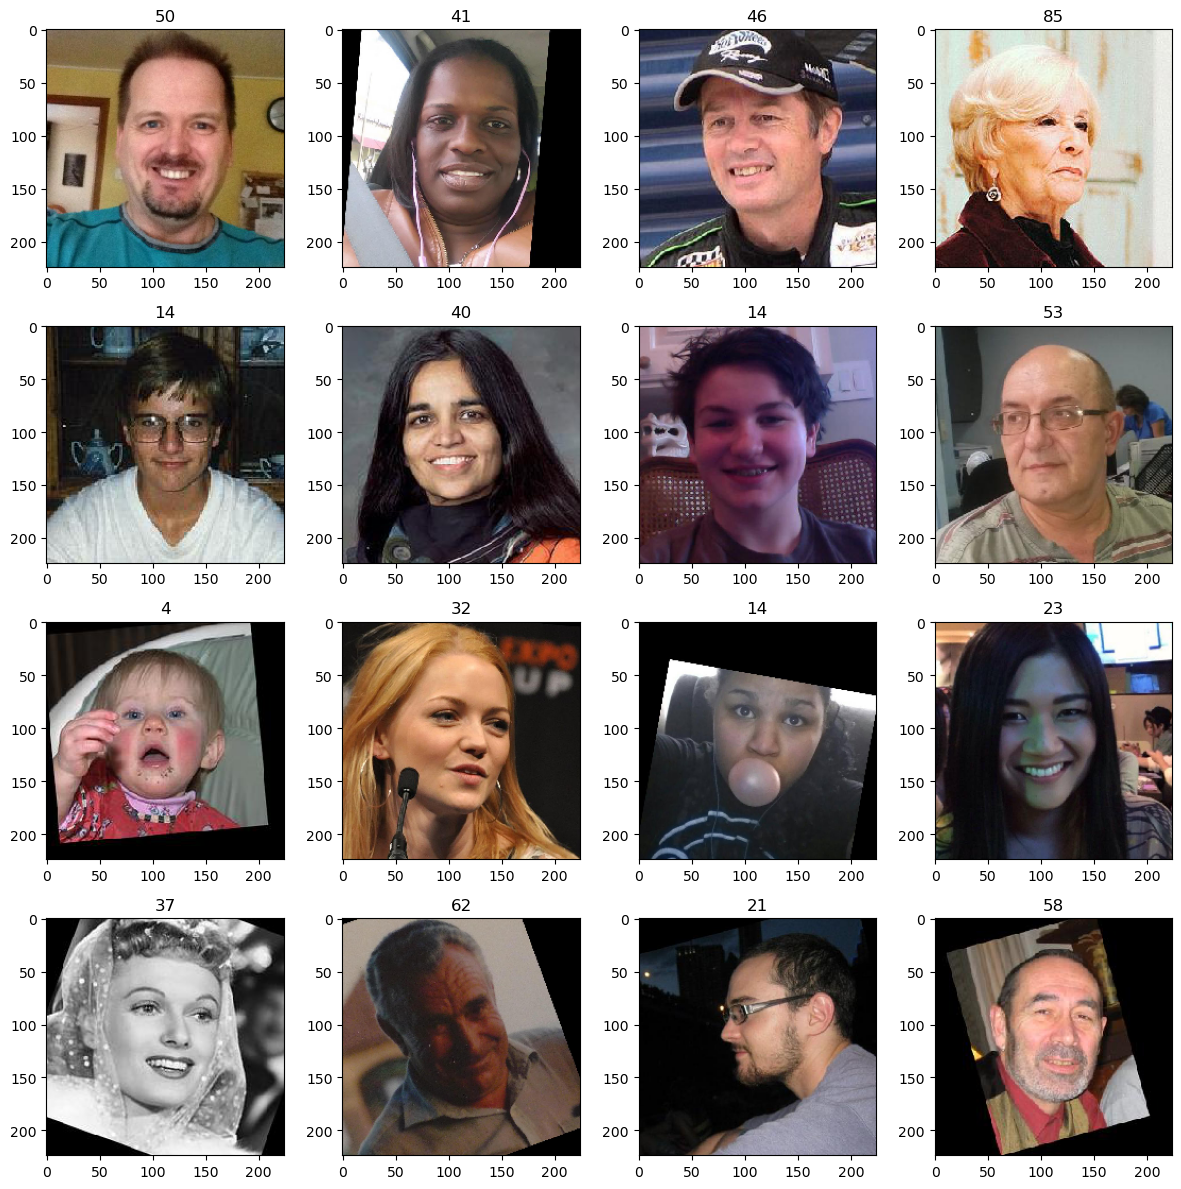

In [11]:
show_images(next(data_gen_flow))

### 3.2. Findings <a id='find'></a>

The dataset consists of 7,591 photos. The data ranges from 1 yr old to 100 yrs old. On average, the real age is 31 yrs with standard deviation of 17 yrs. The distribution of the real age is skewed to the right which means there are more younger people than older people in this dataset.

To perform regression, we require a final layer with one neuron that produces a single output value. To ensure that only positive values are calculated, I will employ the 'ReLu' activation function to convert negative values to zeros. The most appropriate loss function for this task is 'MSE', and we will evaluate performance using the 'MAE' metric, aiming for a score less than 8.

## 4. Modelling <a id='train'></a>

In [12]:
def load_train(path):
    
    """
    This code loads training set from file path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_gen = IDG(rescale=1/255, validation_split=0.25)
    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)

    return train_gen_flow

In [13]:
def load_test(path):
    
    """
    This code loads test set from file path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_gen = IDG(rescale=1/255, validation_split=0.25)
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    This code defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0002),
        loss='mse', metrics=['mae'])
    
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    This code train the model
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data, validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
        verbose=2)

    return model

## 5. Prepare Script to Run on GPU Platform <a id='prep'></a>

In [16]:
# prepare script to run on GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## 6. Output <a id='out'></a>

Train for 356 steps, validate for 119 steps<br>
Epoch 1/25<br>
2023-04-30 11:29:31.555081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10<br>
2023-04-30 11:29:31.795687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7<br>
356/356 - 46s - loss: 212.3524 - mae: 10.7107 - val_loss: 500.1452 - val_mae: 17.2812<br>
Epoch 2/25<br>
356/356 - 37s - loss: 83.3413 - mae: 6.9860 - val_loss: 197.2530 - val_mae: 10.4959<br>
Epoch 3/25<br>
356/356 - 37s - loss: 48.2906 - mae: 5.3622 - val_loss: 108.6384 - val_mae: 7.9651<br>
Epoch 4/25<br>
356/356 - 37s - loss: 34.0387 - mae: 4.4534 - val_loss: 80.2087 - val_mae: 6.7732<br>
Epoch 5/25<br>
356/356 - 37s - loss: 21.5726 - mae: 3.5859 - val_loss: 100.7367 - val_mae: 7.6027<br>
Epoch 6/25<br>
356/356 - 37s - loss: 15.2252 - mae: 2.9800 - val_loss: 76.9170 - val_mae: 6.7363<br>
Epoch 7/25<br>
356/356 - 37s - loss: 14.3785 - mae: 2.8817 - val_loss: 75.0632 - val_mae: 6.7117<br>
Epoch 8/25<br>
356/356 - 37s - loss: 14.1087 - mae: 2.8397 - val_loss: 74.0126 - val_mae: 6.4558<br>
Epoch 9/25<br>
356/356 - 37s - loss: 12.5547 - mae: 2.7323 - val_loss: 73.4337 - val_mae: 6.3877<br>
Epoch 10/25<br>
356/356 - 37s - loss: 11.9663 - mae: 2.6338 - val_loss: 81.3096 - val_mae: 6.7430<br>
Epoch 11/25<br>
356/356 - 37s - loss: 11.8621 - mae: 2.6005 - val_loss: 94.5175 - val_mae: 7.4173<br>
Epoch 12/25<br>
356/356 - 37s - loss: 11.7882 - mae: 2.6236 - val_loss: 72.3596 - val_mae: 6.5122<br>
Epoch 13/25<br>
356/356 - 37s - loss: 12.1895 - mae: 2.6513 - val_loss: 75.6075 - val_mae: 6.5735<br>
Epoch 14/25<br>
356/356 - 37s - loss: 11.7172 - mae: 2.6322 - val_loss: 69.1142 - val_mae: 6.2413<br>
Epoch 15/25<br>
356/356 - 37s - loss: 10.4698 - mae: 2.4494 - val_loss: 82.4406 - val_mae: 6.9636<br>
Epoch 16/25<br>
356/356 - 37s - loss: 9.6524 - mae: 2.3513 - val_loss: 66.9880 - val_mae: 6.2190<br>
Epoch 17/25<br>
356/356 - 37s - loss: 9.0935 - mae: 2.2870 - val_loss: 67.8221 - val_mae: 6.1553<br>
Epoch 18/25<br>
356/356 - 37s - loss: 8.4787 - mae: 2.1945 - val_loss: 74.2692 - val_mae: 6.4776<br>
Epoch 19/25<br>
356/356 - 37s - loss: 8.2519 - mae: 2.1913 - val_loss: 87.5124 - val_mae: 7.2265<br>
Epoch 20/25<br>
356/356 - 37s - loss: 8.6787 - mae: 2.2388 - val_loss: 72.9947 - val_mae: 6.3115<br>
Epoch 21/25<br>
356/356 - 37s - loss: 8.0889 - mae: 2.1716 - val_loss: 77.3789 - val_mae: 6.7618<br>
Epoch 22/25<br>
356/356 - 37s - loss: 9.4425 - mae: 2.3160 - val_loss: 87.8537 - val_mae: 6.7859<br>
Epoch 23/25<br>
356/356 - 37s - loss: 14.1180 - mae: 2.8514 - val_loss: 78.9160 - val_mae: 6.6348<br>
Epoch 24/25<br>
356/356 - 37s - loss: 17.3081 - mae: 3.1216 - val_loss: 78.2839 - val_mae: 6.4340<br>
Epoch 25/25<br>
356/356 - 37s - loss: 15.5956 - mae: 2.8973 - val_loss: 90.9849 - val_mae: 6.9188<br>
WARNING:tensorflow:sample_weight modes were coerced from<br>
  ...<br>
    to  <br>
  ['...']<br>
119/119 - 9s - loss: 90.9849 - mae: 6.9188<br>
Test MAE: 6.9188

## 7. General Conclusion <a id='end'></a>

Based on EDA, the dataset ranges from 1 yr old to 100 yrs old with average of 31 yrs and standard deviation of 17 yrs. There are more younger people than older people in this dataset.

The regressor training is performed without image augmentation. We used ResNet50 architecture and final layer of one neuron to estimate one number. We employed the 'ReLu' activation to make sure that there is no negative values. With the MSE loss function and MAE metric to measure performance, the trained model is able to give MAE of **6.9188** on test dataset which is below our target of 8.

This model has performed well on test dataset and expected to do the same on real world application. This model can be a great solution to prevent selling age-restricted products to underage customers and also to recommend relevant products to customers.